# Clasificación de células cervicales en analisis de PAP en 3 clases 

In [3]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import shutil
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve



## Tipos de Lesiones por Grado
1.	**Normal** (sin lesión): Pacientes que obtuvieron resultados negativos en el test no presentan lesión y deben repetir el examen cada tres años.
2.	**Lesión de bajo grado**: Incluye las lesiones `ASC-US` (células escamosas atípicas de significado indeterminado) y `LSIL` (lesión escamosa intraepitelial de bajo grado). Estas lesiones son indicativas de cambios celulares que pueden resolverse sin tratamiento. En general, se recomienda un seguimiento y repetición del examen en seis meses o un año, dependiendo de la edad del paciente.
3.	**Lesión de alto grado**: Comprende las lesiones `ASC-H` (células escamosas atípicas que no pueden excluir lesión de alto grado), `HSIL` (lesión escamosa intraepitelial de alto grado) y `SCC` (carcinoma de células escamosas). Estas lesiones presentan un mayor riesgo de progresión a cáncer, por lo que se recomienda realizar una colposcopía y, si es necesario, una biopsia para su diagnóstico y tratamiento adecuado.

## Visualización de datos 

**Visualización de datos (crops)**

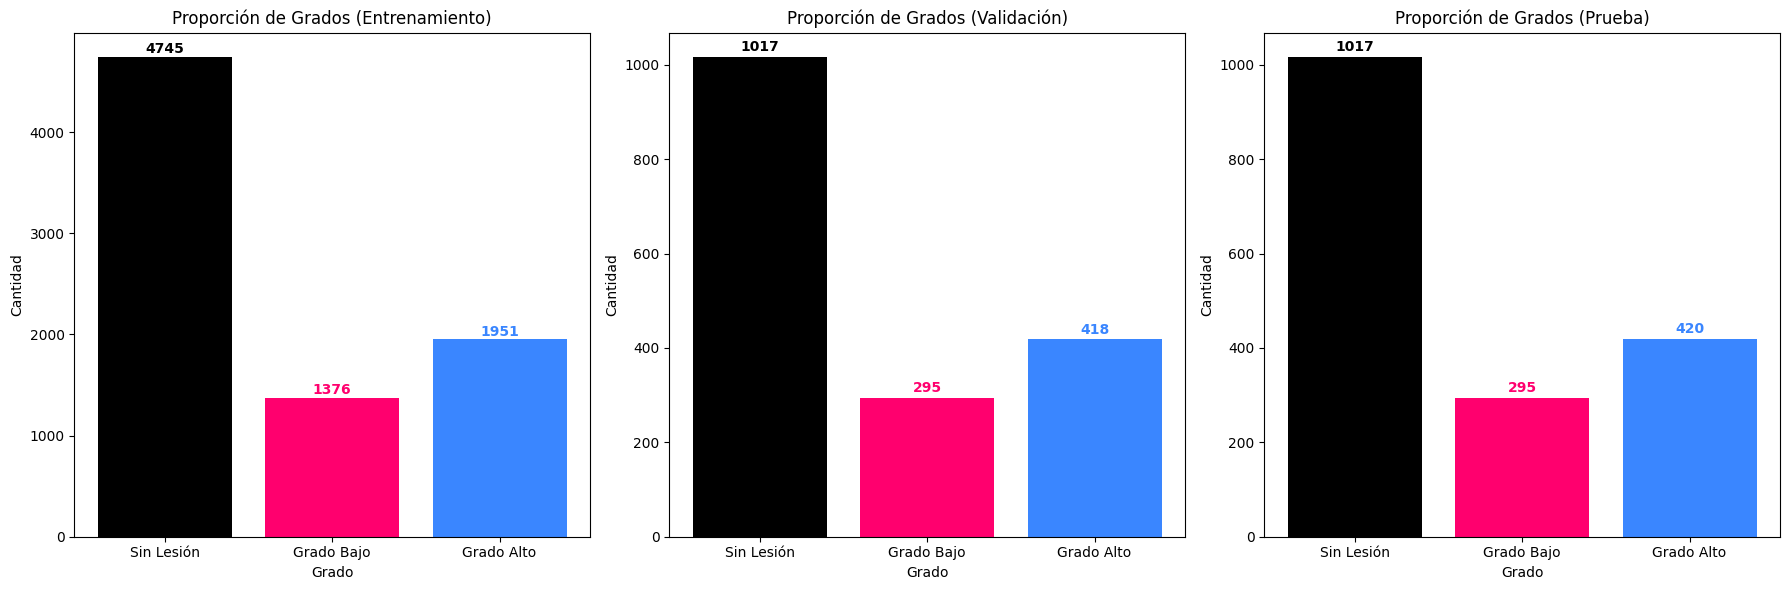

In [62]:
import os
import matplotlib.pyplot as plt

# Definir las carpetas para cada grado
no_lesion_class = 'Negative'
low_grade_class = 'low_grade'
high_grade_class = 'high_grade'

# Función para contar imágenes por grado dentro de "sin lesión", "grado bajo" y "grado alto"
def count_images_by_grade(folder_path):
    # Inicializar los contadores
    grade_counts = {'Sin Lesión': 0, 'Grado Bajo': 0, 'Grado Alto': 0}

    # Contar imágenes en la carpeta "sin lesión"
    no_lesion_folder = os.path.join(folder_path, no_lesion_class)
    grade_counts['Sin Lesión'] = len(os.listdir(no_lesion_folder)) if os.path.exists(no_lesion_folder) else 0

    # Contar imágenes en todas las subcarpetas de "grado bajo"
    low_grade_folder = os.path.join(folder_path, low_grade_class)
    if os.path.exists(low_grade_folder):
        for subfolder in os.listdir(low_grade_folder):
            subfolder_path = os.path.join(low_grade_folder, subfolder)
            if os.path.isdir(subfolder_path):
                grade_counts['Grado Bajo'] += len(os.listdir(subfolder_path))

    # Contar imágenes en todas las subcarpetas de "grado alto"
    high_grade_folder = os.path.join(folder_path, high_grade_class)
    if os.path.exists(high_grade_folder):
        for subfolder in os.listdir(high_grade_folder):
            subfolder_path = os.path.join(high_grade_folder, subfolder)
            if os.path.isdir(subfolder_path):
                grade_counts['Grado Alto'] += len(os.listdir(subfolder_path))

    return grade_counts

# Función para crear gráficos de barras para las proporciones de cada grado
def plot_grade_proportion(ax, grade_counts, title, colors):
    # Crear el gráfico de barras en el subplot
    grades = list(grade_counts.keys())
    counts = list(grade_counts.values())
    ax.bar(grades, counts, color=colors[:len(grades)])
    ax.set_xlabel('Grado')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    for i, count in enumerate(counts):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold', color=colors[i])

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_3classes/train'
val_dir = 'crops_3classes/val'
test_dir = 'crops_3classes/test'

# Contar las imágenes en cada conjunto por grado
train_grade_counts = count_images_by_grade(train_dir)
val_grade_counts = count_images_by_grade(val_dir)
test_grade_counts = count_images_by_grade(test_dir)

# Colores para cada grado
colors = ['#000000', '#FF006E', '#3A86FF']  # Negro para 'Sin Lesión', Rojo para 'Grado Bajo', y Azul para 'Grado Alto'

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_grade_proportion(axes[0], train_grade_counts, 'Proporción de Grados (Entrenamiento)', colors)
plot_grade_proportion(axes[1], val_grade_counts, 'Proporción de Grados (Validación)', colors)
plot_grade_proportion(axes[2], test_grade_counts, 'Proporción de Grados (Prueba)', colors)

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

## Aumentación de datos

In [77]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

# Directorio base para las imágenes
base_dir = 'crops_3classes'  # Asegúrate de que este es el directorio correcto
augmented_dir = 'crops_3classes_aug'  # Directorio para guardar imágenes aumentadas

# Configuración de la aumentación
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Función para generar imágenes aumentadas
def augment_images(class_group, class_name, target_count):
    original_dir = os.path.join(base_dir, 'train', class_group, class_name)
    augmented_class_dir = os.path.join(augmented_dir, 'train', class_group, class_name)
    os.makedirs(augmented_class_dir, exist_ok=True)  # Asegura que el directorio exista
    image_files = os.listdir(original_dir)

    current_count = len(image_files)
    extra_count = int(current_count * 0.5)  # Generar 50% más imágenes
    generated_count = 0

    while generated_count < extra_count:
        img_file = np.random.choice(image_files)  # Elegir una imagen al azar
        img_path = os.path.join(original_dir, img_file)
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Generar una imagen aumentada
        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)

        # Guardar la imagen aumentada en el directorio correspondiente
        new_img_name = f"{class_name}_aug_{current_count + generated_count}.png"
        save_img(os.path.join(augmented_class_dir, new_img_name), aug_img)

        generated_count += 1

# Clases y sus correspondientes directorios
class_groups = {
    'high_grade': ['ASC-H', 'HSIL', 'SCC'],
    'low_grade': ['ASC-US', 'LSIL'],
    'Negative': []  # Sin subcarpetas para la clase Negative
}

# Generar las imágenes aumentadas solo para las clases en el conjunto de entrenamiento
for group, classes in class_groups.items():
    for class_name in classes:
        target_count = len(os.listdir(os.path.join(base_dir, 'train', group, class_name)))
        print(f"Generando {int(target_count * 0.5)} imágenes aumentadas para {class_name} en 'train'")
        augment_images(group, class_name, target_count)

print("Aumentación de datos completada. Las imágenes se guardaron en el directorio 'crops_3classes_aug'.")

Generando 323 imágenes aumentadas para ASC-H en 'train'
Generando 596 imágenes aumentadas para HSIL en 'train'
Generando 56 imágenes aumentadas para SCC en 'train'
Generando 212 imágenes aumentadas para ASC-US en 'train'
Generando 476 imágenes aumentadas para LSIL en 'train'
Aumentación de datos completada. Las imágenes se guardaron en el directorio 'crops_3classes_aug'.


**Visualización de datos con aumentación (crops_aug)**

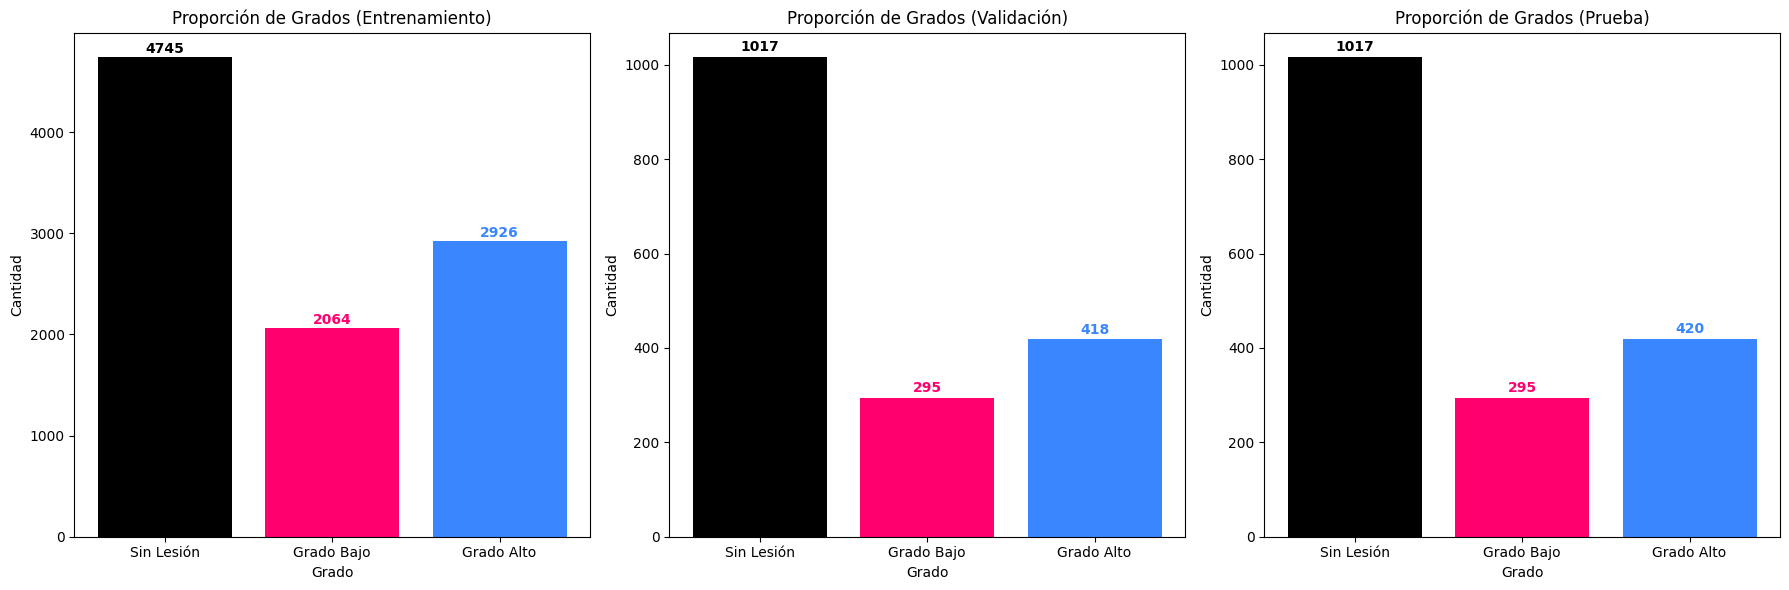

In [14]:
import os
import matplotlib.pyplot as plt

# Definir las carpetas para cada grado
no_lesion_class = 'Negative'
low_grade_class = 'low_grade'
high_grade_class = 'high_grade'

# Función para contar imágenes por grado dentro de "sin lesión", "grado bajo" y "grado alto"
def count_images_by_grade(folder_path):
    # Inicializar los contadores
    grade_counts = {'Sin Lesión': 0, 'Grado Bajo': 0, 'Grado Alto': 0}

    # Contar imágenes en la carpeta "sin lesión"
    no_lesion_folder = os.path.join(folder_path, no_lesion_class)
    grade_counts['Sin Lesión'] = len(os.listdir(no_lesion_folder)) if os.path.exists(no_lesion_folder) else 0

    # Contar imágenes en todas las subcarpetas de "grado bajo"
    low_grade_folder = os.path.join(folder_path, low_grade_class)
    if os.path.exists(low_grade_folder):
        for subfolder in os.listdir(low_grade_folder):
            subfolder_path = os.path.join(low_grade_folder, subfolder)
            if os.path.isdir(subfolder_path):
                grade_counts['Grado Bajo'] += len(os.listdir(subfolder_path))

    # Contar imágenes en todas las subcarpetas de "grado alto"
    high_grade_folder = os.path.join(folder_path, high_grade_class)
    if os.path.exists(high_grade_folder):
        for subfolder in os.listdir(high_grade_folder):
            subfolder_path = os.path.join(high_grade_folder, subfolder)
            if os.path.isdir(subfolder_path):
                grade_counts['Grado Alto'] += len(os.listdir(subfolder_path))

    return grade_counts

# Función para crear gráficos de barras para las proporciones de cada grado
def plot_grade_proportion(ax, grade_counts, title, colors):
    # Crear el gráfico de barras en el subplot
    grades = list(grade_counts.keys())
    counts = list(grade_counts.values())
    ax.bar(grades, counts, color=colors[:len(grades)])
    ax.set_xlabel('Grado')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    for i, count in enumerate(counts):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold', color=colors[i])

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_3classes_aug/train'
val_dir = 'crops_3classes_aug/val'
test_dir = 'crops_3classes_aug/test'

# Contar las imágenes en cada conjunto por grado
train_grade_counts = count_images_by_grade(train_dir)
val_grade_counts = count_images_by_grade(val_dir)
test_grade_counts = count_images_by_grade(test_dir)

# Colores para cada grado
colors = ['#000000', '#FF006E', '#3A86FF']  # Negro para 'Sin Lesión', Rojo para 'Grado Bajo', y Azul para 'Grado Alto'

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_grade_proportion(axes[0], train_grade_counts, 'Proporción de Grados (Entrenamiento)', colors)
plot_grade_proportion(axes[1], val_grade_counts, 'Proporción de Grados (Validación)', colors)
plot_grade_proportion(axes[2], test_grade_counts, 'Proporción de Grados (Prueba)', colors)

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

## Generador de datos

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio base para las imágenes agrupadas en tres clases
base_dir = 'crops_3classes'  # Cambia esta ruta si es diferente

# Configuración del generador con rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Parámetros
target_size = (224, 224)  # Cambia el tamaño si es necesario
batch_size = 32
class_mode = 'categorical'

# Crear generadores para entrenamiento, validación y prueba
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)

# con aumentación
train_generator_aug = train_datagen.flow_from_directory(
    directory=os.path.join('crops_3classes_aug', 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)


val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

# Verificar clases asignadas a cada generador
print("Clases de entrenamiento:", train_generator.class_indices)
print("Clases de entrenamiento con aumentación:", train_generator_aug.class_indices)
print("Clases de validación:", val_generator.class_indices)
print("Clases de prueba:", test_generator.class_indices)

Found 8072 images belonging to 3 classes.
Found 9735 images belonging to 3 classes.
Found 1730 images belonging to 3 classes.
Found 1732 images belonging to 3 classes.
Clases de entrenamiento: {'Negative': 0, 'high_grade': 1, 'low_grade': 2}
Clases de entrenamiento con aumentación: {'Negative': 0, 'high_grade': 1, 'low_grade': 2}
Clases de validación: {'Negative': 0, 'high_grade': 1, 'low_grade': 2}
Clases de prueba: {'Negative': 0, 'high_grade': 1, 'low_grade': 2}


## MovileNetV2

### Con crops_3classes

In [85]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Parámetros del modelo y configuración
input_shape = (96, 96, 3)  # Asegúrate de que el tamaño de entrada coincide con el de los generadores
num_classes = len(class_indices)  # Número de grados: sin lesión, grado bajo, grado alto

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Congelemos las capas base para entrenamiento inicial

# Añadir capas personalizadas en la parte superior
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce la dimensionalidad
    layers.Dense(128, activation='relu'),  # Capa densa con 128 neuronas
    layers.Dropout(0.3),  # Regularización para evitar overfitting
    layers.Dense(num_classes, activation='softmax')  # Capa de salida
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Pérdida para clasificación multiclase
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

# Configurar callbacks para el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test_generator)
print(f"\nResultados en el conjunto de prueba:\n- Pérdida: {test_loss:.4f}\n- Precisión: {test_accuracy:.4f}\n- Recall: {test_recall:.4f}\n- Precision: {test_precision:.4f}")

Epoch 1/30
253/253 [==============================] - 13s 45ms/step - loss: 0.8630 - accuracy: 0.6485 - recall_8: 0.6001 - precision_8: 0.6841 - val_loss: 0.6416 - val_accuracy: 0.7335 - val_recall_8: 0.6566 - val_precision_8: 0.7894 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 11s 44ms/step - loss: 0.6504 - accuracy: 0.7239 - recall_8: 0.6594 - precision_8: 0.7757 - val_loss: 0.6000 - val_accuracy: 0.7462 - val_recall_8: 0.6792 - val_precision_8: 0.8048 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 11s 43ms/step - loss: 0.5932 - accuracy: 0.7563 - recall_8: 0.6947 - precision_8: 0.8006 - val_loss: 0.5772 - val_accuracy: 0.7572 - val_recall_8: 0.7000 - val_precision_8: 0.8205 - lr: 1.0000e-04
Epoch 4/30
253/253 [==============================] - 11s 44ms/step - loss: 0.5602 - accuracy: 0.7707 - recall_8: 0.7127 - precision_8: 0.8149 - val_loss: 0.5634 - val_accuracy: 0.7659 - val_recall_8: 0.7185 - val_precision_8: 0.8151 - lr: 1.0000e

#### Evaluación

**Matriz de confusión**

55/55 [==============================] - 3s 39ms/step


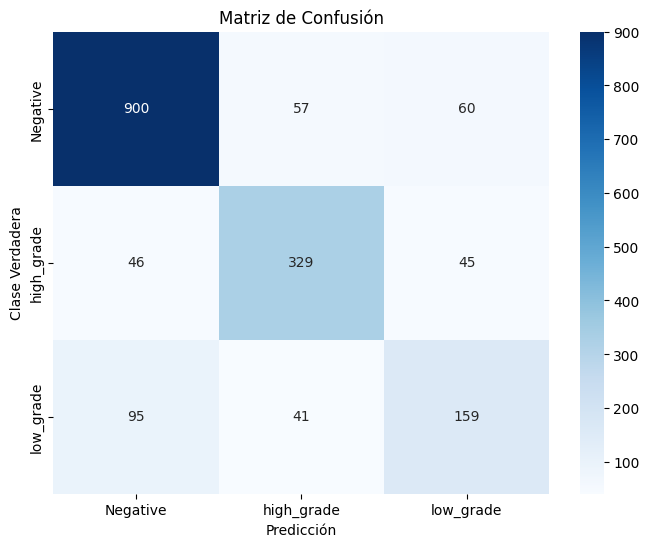


Reporte de clasificación:
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      1017
  high_grade       0.77      0.78      0.78       420
   low_grade       0.60      0.54      0.57       295

    accuracy                           0.80      1732
   macro avg       0.75      0.74      0.74      1732
weighted avg       0.80      0.80      0.80      1732



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Asumiendo que ya tienes un modelo entrenado (cárgalo si es necesario)
# model = load_model('ruta_al_modelo_entrenado.h5')

# Realizar predicciones en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1  # Calcular los pasos necesarios para evaluar todo el conjunto
predictions = model.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases (Negative, low_grade, high_grade)

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

**Curva ROC**

55/55 [==============================] - 2s 41ms/step


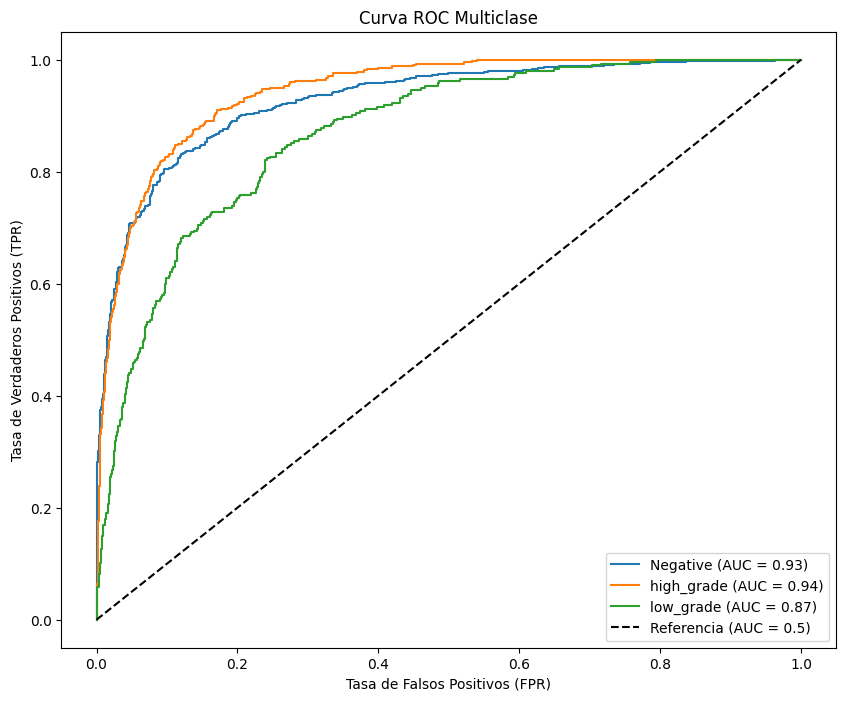

AUC promedio (macro): 0.91


In [87]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Asegúrate de que tienes las etiquetas y predicciones en formato binarizado
# Etiquetas verdaderas en formato one-hot encoding
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases
num_classes = len(class_labels)

# Binarizar las etiquetas verdaderas
y_true = label_binarize(true_classes, classes=[i for i in range(num_classes)])

# Predecir las probabilidades en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

# Crear la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Curva ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', label="Referencia (AUC = 0.5)")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC Multiclase")
plt.legend(loc="lower right")
plt.show()

# Calcular el AUC promedio (macro)
roc_auc_avg = roc_auc_score(y_true, y_pred_proba, average="macro")
print(f"AUC promedio (macro): {roc_auc_avg:.2f}")

**Curva precisión-recall**

55/55 [==============================] - 2s 39ms/step


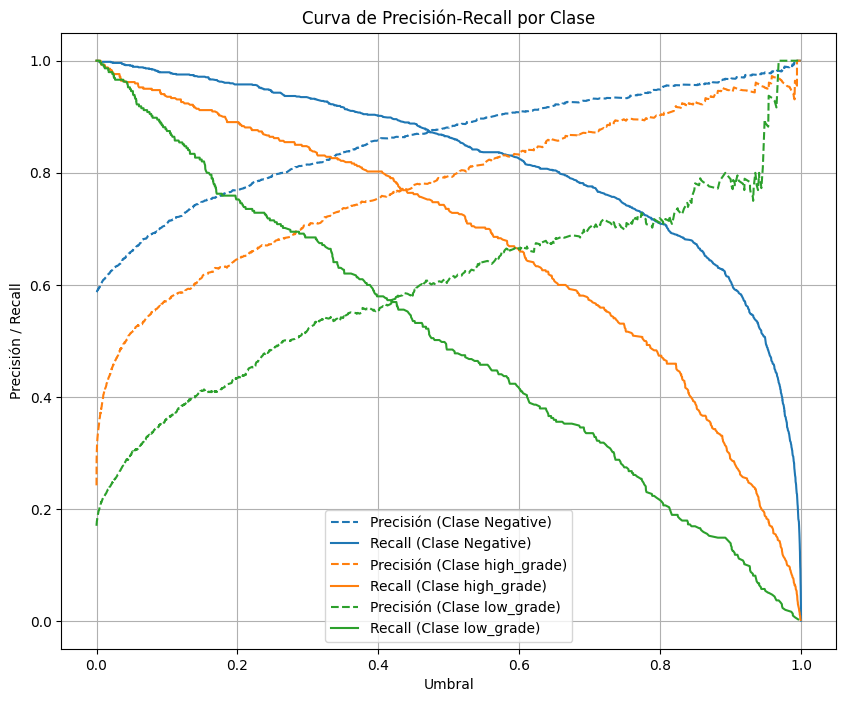

In [88]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Etiquetas verdaderas en formato one-hot encoding
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases
num_classes = len(class_labels)

# Binarizar las etiquetas verdaderas
y_true = label_binarize(true_classes, classes=[i for i in range(num_classes)])

# Predecir las probabilidades en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

# Graficar la curva de precisión-recall para cada clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
    plt.plot(thresholds, precision[:-1], label=f'Precisión (Clase {class_labels[i]})', color=f'C{i}', linestyle='--')
    plt.plot(thresholds, recall[:-1], label=f'Recall (Clase {class_labels[i]})', color=f'C{i}')

plt.xlabel("Umbral")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall por Clase")
plt.legend(loc="best")
plt.grid(True)
plt.show()

### Con crops_3classes_aug (aumentación)

In [81]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Parámetros del modelo y configuración
input_shape = (96, 96, 3)  # Asegúrate de que el tamaño de entrada coincide con el de los generadores
num_classes = len(class_indices)  # Número de grados: sin lesión, grado bajo, grado alto

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Congelemos las capas base para entrenamiento inicial

# Añadir capas personalizadas en la parte superior
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce la dimensionalidad
    layers.Dense(128, activation='relu'),  # Capa densa con 128 neuronas
    layers.Dropout(0.3),  # Regularización para evitar overfitting
    layers.Dense(num_classes, activation='softmax')  # Capa de salida
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Pérdida para clasificación multiclase
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

# Configurar callbacks para el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Entrenar el modelo
history = model.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test_generator)
print(f"\nResultados en el conjunto de prueba:\n- Pérdida: {test_loss:.4f}\n- Precisión: {test_accuracy:.4f}\n- Recall: {test_recall:.4f}\n- Precision: {test_precision:.4f}")

Epoch 1/30
305/305 [==============================] - 16s 49ms/step - loss: 0.9631 - accuracy: 0.6155 - recall_7: 0.5576 - precision_7: 0.6496 - val_loss: 0.6416 - val_accuracy: 0.7249 - val_recall_7: 0.6491 - val_precision_7: 0.7756 - lr: 1.0000e-04
Epoch 2/30
305/305 [==============================] - 14s 45ms/step - loss: 0.6864 - accuracy: 0.7097 - recall_7: 0.6356 - precision_7: 0.7584 - val_loss: 0.5962 - val_accuracy: 0.7601 - val_recall_7: 0.6838 - val_precision_7: 0.8125 - lr: 1.0000e-04
Epoch 3/30
305/305 [==============================] - 13s 44ms/step - loss: 0.6240 - accuracy: 0.7400 - recall_7: 0.6779 - precision_7: 0.7854 - val_loss: 0.5677 - val_accuracy: 0.7775 - val_recall_7: 0.6988 - val_precision_7: 0.8186 - lr: 1.0000e-04
Epoch 4/30
305/305 [==============================] - 14s 44ms/step - loss: 0.5836 - accuracy: 0.7587 - recall_7: 0.7008 - precision_7: 0.8057 - val_loss: 0.5519 - val_accuracy: 0.7832 - val_recall_7: 0.7231 - val_precision_7: 0.8193 - lr: 1.0000e

#### Evaluación

**Matriz de confusión**

55/55 [==============================] - 3s 38ms/step


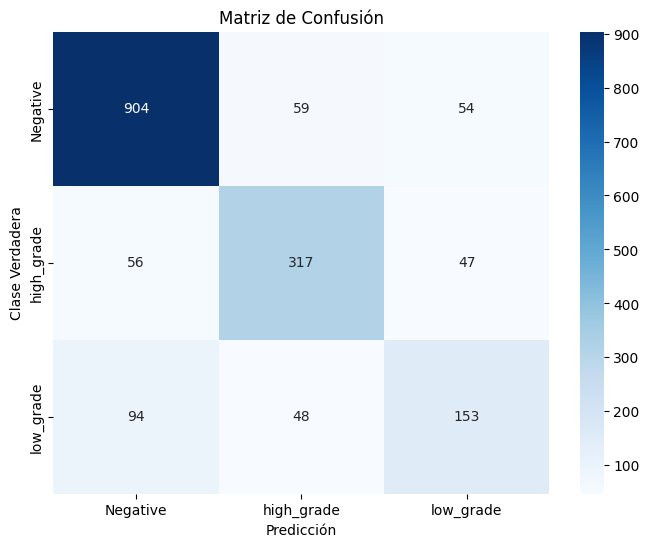


Reporte de clasificación:
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87      1017
  high_grade       0.75      0.75      0.75       420
   low_grade       0.60      0.52      0.56       295

    accuracy                           0.79      1732
   macro avg       0.74      0.72      0.73      1732
weighted avg       0.79      0.79      0.79      1732



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Asumiendo que ya tienes un modelo entrenado (cárgalo si es necesario)
# model = load_model('ruta_al_modelo_entrenado.h5')

# Realizar predicciones en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1  # Calcular los pasos necesarios para evaluar todo el conjunto
predictions = model.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases (Negative, low_grade, high_grade)

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

**Curva ROC**

55/55 [==============================] - 2s 41ms/step


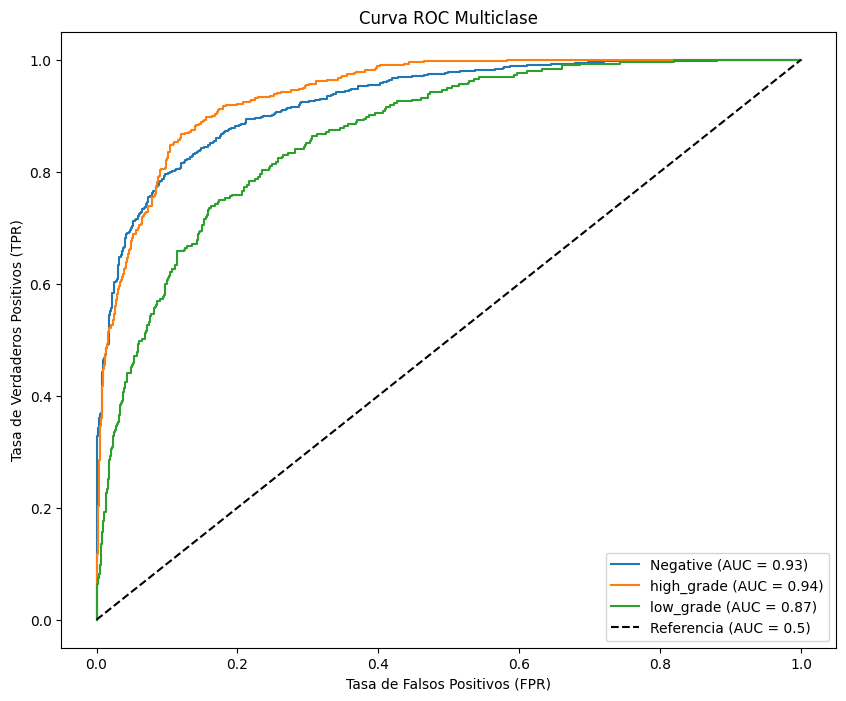

AUC promedio (macro): 0.91


In [83]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Asegúrate de que tienes las etiquetas y predicciones en formato binarizado
# Etiquetas verdaderas en formato one-hot encoding
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases
num_classes = len(class_labels)

# Binarizar las etiquetas verdaderas
y_true = label_binarize(true_classes, classes=[i for i in range(num_classes)])

# Predecir las probabilidades en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

# Crear la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Curva ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', label="Referencia (AUC = 0.5)")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC Multiclase")
plt.legend(loc="lower right")
plt.show()

# Calcular el AUC promedio (macro)
roc_auc_avg = roc_auc_score(y_true, y_pred_proba, average="macro")
print(f"AUC promedio (macro): {roc_auc_avg:.2f}")

**Curva precisión-recall**

55/55 [==============================] - 2s 39ms/step


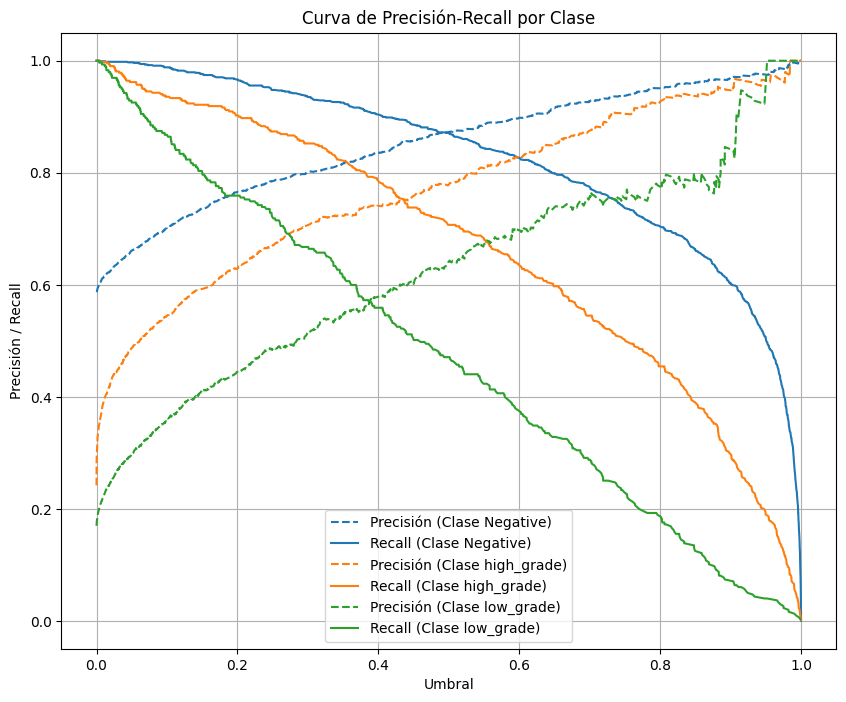

In [84]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Etiquetas verdaderas en formato one-hot encoding
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases
num_classes = len(class_labels)

# Binarizar las etiquetas verdaderas
y_true = label_binarize(true_classes, classes=[i for i in range(num_classes)])

# Predecir las probabilidades en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

# Graficar la curva de precisión-recall para cada clase
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
    plt.plot(thresholds, precision[:-1], label=f'Precisión (Clase {class_labels[i]})', color=f'C{i}', linestyle='--')
    plt.plot(thresholds, recall[:-1], label=f'Recall (Clase {class_labels[i]})', color=f'C{i}')

plt.xlabel("Umbral")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall por Clase")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## XceptionNet

### Con crops_3classes

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Parámetros del modelo y configuración
input_shape = (224, 224, 3)  # Asegúrate de que el tamaño de entrada coincide con el de los generadores
num_classes = 3  # Número de grados: sin lesión, grado bajo, grado alto

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = Xception(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Congelemos las capas base para entrenamiento inicial

# Añadir capas personalizadas en la parte superior
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce la dimensionalidad
    layers.Dense(512, activation='relu'),  # Capa densa con 128 neuronas
    layers.Dropout(0.3),  # Regularización para evitar overfitting
    layers.Dense(num_classes, activation='softmax')  # Capa de salida
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Pérdida para clasificación multiclase
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

# Configurar callbacks para el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test_generator)
print(f"\nResultados en el conjunto de prueba:\n- Pérdida: {test_loss:.4f}\n- Precisión: {test_accuracy:.4f}\n- Recall: {test_recall:.4f}\n- Precision: {test_precision:.4f}")

Epoch 1/30
253/253 [==============================] - 231s 911ms/step - loss: 0.6140 - accuracy: 0.7463 - recall: 0.6664 - precision: 0.8088 - val_loss: 0.5079 - val_accuracy: 0.8087 - val_recall: 0.7509 - val_precision: 0.8419 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 236s 934ms/step - loss: 0.4914 - accuracy: 0.8093 - recall: 0.7600 - precision: 0.8408 - val_loss: 0.4723 - val_accuracy: 0.8249 - val_recall: 0.7769 - val_precision: 0.8458 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 254s 1s/step - loss: 0.4441 - accuracy: 0.8235 - recall: 0.7901 - precision: 0.8551 - val_loss: 0.4603 - val_accuracy: 0.8243 - val_recall: 0.7884 - val_precision: 0.8472 - lr: 1.0000e-04
Epoch 4/30
253/253 [==============================] - 265s 1s/step - loss: 0.4116 - accuracy: 0.8420 - recall: 0.8102 - precision: 0.8694 - val_loss: 0.4616 - val_accuracy: 0.8237 - val_recall: 0.7919 - val_precision: 0.8457 - lr: 1.0000e-04
Epoch 5/30
253/253 [======

#### Evaluación

**Matriz de confusión**

55/55 [==============================] - 42s 758ms/step


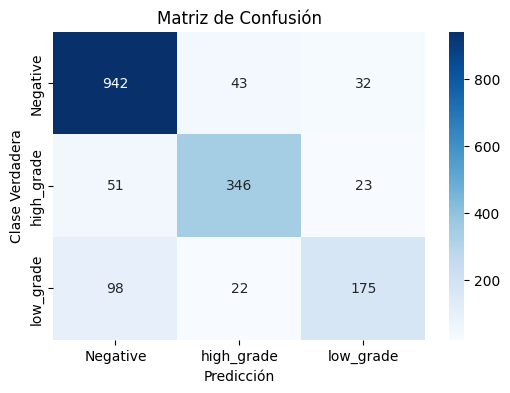


Reporte de clasificación:
              precision    recall  f1-score   support

    Negative       0.86      0.93      0.89      1017
  high_grade       0.84      0.82      0.83       420
   low_grade       0.76      0.59      0.67       295

    accuracy                           0.84      1732
   macro avg       0.82      0.78      0.80      1732
weighted avg       0.84      0.84      0.84      1732



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Asumiendo que ya tienes un modelo entrenado (cárgalo si es necesario)
# model = load_model('ruta_al_modelo_entrenado.h5')

# Realizar predicciones en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1  # Calcular los pasos necesarios para evaluar todo el conjunto
predictions = model.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases (Negative, low_grade, high_grade)

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

**Curva ROC**

55/55 [==============================] - 42s 761ms/step


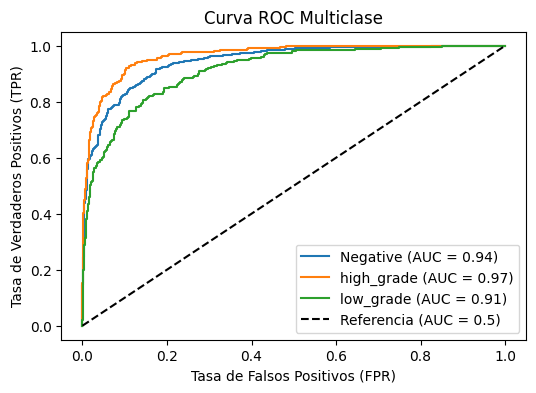

AUC promedio (macro): 0.94


In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Asegúrate de que tienes las etiquetas y predicciones en formato binarizado
# Etiquetas verdaderas en formato one-hot encoding
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases
num_classes = len(class_labels)

# Binarizar las etiquetas verdaderas
y_true = label_binarize(true_classes, classes=[i for i in range(num_classes)])

# Predecir las probabilidades en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

# Crear la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Curva ROC para cada clase
plt.figure(figsize=(6, 4))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', label="Referencia (AUC = 0.5)")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC Multiclase")
plt.legend(loc="lower right")
plt.show()

# Calcular el AUC promedio (macro)
roc_auc_avg = roc_auc_score(y_true, y_pred_proba, average="macro")
print(f"AUC promedio (macro): {roc_auc_avg:.2f}")

**Curva precisión-recall**

55/55 [==============================] - 42s 759ms/step


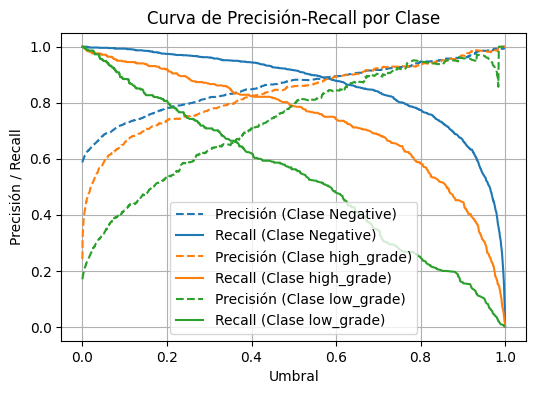

In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Etiquetas verdaderas en formato one-hot encoding
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases
num_classes = len(class_labels)

# Binarizar las etiquetas verdaderas
y_true = label_binarize(true_classes, classes=[i for i in range(num_classes)])

# Predecir las probabilidades en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

# Graficar la curva de precisión-recall para cada clase
plt.figure(figsize=(6, 4))
for i in range(num_classes):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
    plt.plot(thresholds, precision[:-1], label=f'Precisión (Clase {class_labels[i]})', color=f'C{i}', linestyle='--')
    plt.plot(thresholds, recall[:-1], label=f'Recall (Clase {class_labels[i]})', color=f'C{i}')

plt.xlabel("Umbral")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall por Clase")
plt.legend(loc="best")
plt.grid(True)
plt.show()

### Con crops_3classes_aug (aumentación)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Parámetros del modelo y configuración
input_shape = (224, 224, 3)
num_classes = 3  # Ajustar según la cantidad real de clases que tienes

# Cargar Xception preentrenado en ImageNet, sin la capa superior
base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
base_model.trainable = True  # Si quieres hacer fine-tuning desde el inicio, de otra manera establece algunos como no entrenables

# Añadir capas personalizadas en la parte superior
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compilar el modelo con las métricas apropiadas
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Configurar callbacks para el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Entrenar el modelo
history = model.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluar el modelo en el conjunto de prueba
test_metrics = model.evaluate(test_generator)
print(f"\nResultados en el conjunto de prueba:\n- Pérdida: {test_metrics[0]:.4f}\n- Precisión: {test_metrics[1]:.4f}\n- Precision: {test_metrics[2]:.4f}\n- Recall: {test_metrics[3]:.4f}")

# - Pérdida: 0.3640
# - Precisión: 0.8666
# - Precision: 0.8753
# - Recall: 0.8591

Epoch 1/30
305/305 [==============================] - 1373s 4s/step - loss: 0.6121 - accuracy: 0.7743 - precision: 0.7969 - recall: 0.7464 - val_loss: 0.5721 - val_accuracy: 0.8520 - val_precision: 0.9511 - val_recall: 0.6746 - lr: 1.0000e-04
Epoch 2/30
305/305 [==============================] - 1361s 4s/step - loss: 0.2404 - accuracy: 0.9120 - precision: 0.9183 - recall: 0.9030 - val_loss: 0.3178 - val_accuracy: 0.8838 - val_precision: 0.9007 - val_recall: 0.8595 - lr: 1.0000e-04
Epoch 3/30
305/305 [==============================] - 1268s 4s/step - loss: 0.1156 - accuracy: 0.9619 - precision: 0.9639 - recall: 0.9599 - val_loss: 0.3552 - val_accuracy: 0.8994 - val_precision: 0.9010 - val_recall: 0.8948 - lr: 1.0000e-04
Epoch 4/30
305/305 [==============================] - 1270s 4s/step - loss: 0.0630 - accuracy: 0.9779 - precision: 0.9791 - recall: 0.9771 - val_loss: 0.4225 - val_accuracy: 0.8977 - val_precision: 0.9013 - val_recall: 0.8971 - lr: 1.0000e-04
Epoch 5/30
55/55 [==========

In [15]:
model.save('modelosFinales/xception_clasificacion3clases_aug.keras')

#### Evaluación

**Matriz de confusión**

55/55 [==============================] - 42s 756ms/step


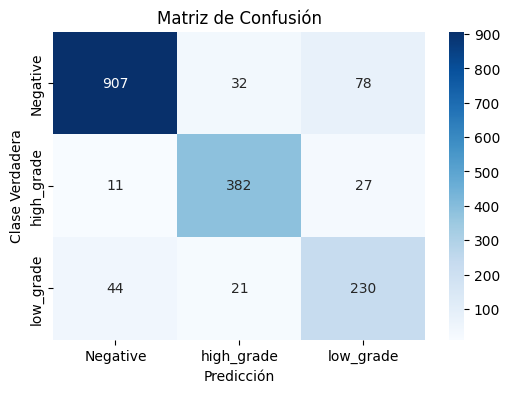


Reporte de clasificación:
              precision    recall  f1-score   support

    Negative       0.94      0.89      0.92      1017
  high_grade       0.88      0.91      0.89       420
   low_grade       0.69      0.78      0.73       295

    accuracy                           0.88      1732
   macro avg       0.84      0.86      0.85      1732
weighted avg       0.88      0.88      0.88      1732



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Asumiendo que ya tienes un modelo entrenado (cárgalo si es necesario)
# model = load_model('ruta_al_modelo_entrenado.h5')

# Realizar predicciones en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1  # Calcular los pasos necesarios para evaluar todo el conjunto
predictions = model.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases (Negative, low_grade, high_grade)

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 919, 347, 126
# Reporte de clasificación:
#               precision    recall  f1-score   support

#     Negative       0.84      0.90      0.87      1017
#   high_grade       0.76      0.83      0.79       420
#    low_grade       0.70      0.43      0.53       295

#     accuracy                           0.80      1732
#    macro avg       0.77      0.72      0.73      1732
# weighted avg       0.80      0.80      0.79      1732


**Curva ROC**

55/55 [==============================] - 42s 756ms/step


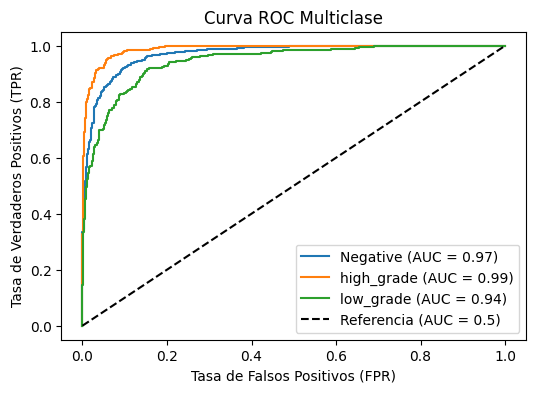

AUC promedio (macro): 0.97


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Asegúrate de que tienes las etiquetas y predicciones en formato binarizado
# Etiquetas verdaderas en formato one-hot encoding
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases
num_classes = len(class_labels)

# Binarizar las etiquetas verdaderas
y_true = label_binarize(true_classes, classes=[i for i in range(num_classes)])

# Predecir las probabilidades en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

# Crear la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Curva ROC para cada clase
plt.figure(figsize=(6, 4))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', label="Referencia (AUC = 0.5)")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC Multiclase")
plt.legend(loc="lower right")
plt.show()

# Calcular el AUC promedio (macro)
roc_auc_avg = roc_auc_score(y_true, y_pred_proba, average="macro")
print(f"AUC promedio (macro): {roc_auc_avg:.2f}")


**Curva precisión-recall**

55/55 [==============================] - 46s 832ms/step


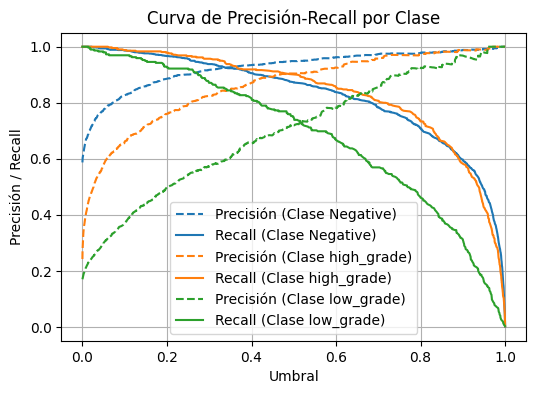

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Etiquetas verdaderas en formato one-hot encoding
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases
num_classes = len(class_labels)

# Binarizar las etiquetas verdaderas
y_true = label_binarize(true_classes, classes=[i for i in range(num_classes)])

# Predecir las probabilidades en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

# Graficar la curva de precisión-recall para cada clase
plt.figure(figsize=(6, 4))
for i in range(num_classes):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
    plt.plot(thresholds, precision[:-1], label=f'Precisión (Clase {class_labels[i]})', color=f'C{i}', linestyle='--')
    plt.plot(thresholds, recall[:-1], label=f'Recall (Clase {class_labels[i]})', color=f'C{i}')

plt.xlabel("Umbral")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall por Clase")
plt.legend(loc="best")
plt.grid(True)
plt.show()